# Sử dụng XGBOOST decision tree để train model.

>[1.Model Theory](#scrollTo=fVmjNe6Qha08)

>>>[1.1 Dữ liệu huấn luyện](#scrollTo=fVmjNe6Qha08)

>>>[1.2 Học dần](#scrollTo=fVmjNe6Qha08)

>>>[1.3 Thêm cây mới](#scrollTo=fVmjNe6Qha08)

>>>[1.4 Tốc độ học (Learning rate)](#scrollTo=fVmjNe6Qha08)

>>>[1.4 Kết quả cuối cùng](#scrollTo=fVmjNe6Qha08)

>>[Mối liên hệ giữa lý thuyết và XGBoost](#scrollTo=fVmjNe6Qha08)

>[Phân tích toán học của Short Time Fourier Transform (STFT)](#scrollTo=Hd9_UNZaO3WC)

>>>[1. Định nghĩa cơ bản của STFT](#scrollTo=Hd9_UNZaO3WC)

>>>[2. Các bước phân tích](#scrollTo=Hd9_UNZaO3WC)

>>>>[Bước 1: Cửa sổ hóa tín hiệu](#scrollTo=Hd9_UNZaO3WC)

>>>>[Bước 2: Biến đổi Fourier trên đoạn cục bộ](#scrollTo=Hd9_UNZaO3WC)

>>>>[Ý nghĩa:](#scrollTo=Hd9_UNZaO3WC)

>>>[3. Miền rời rạc (Discrete STFT - DFT)](#scrollTo=Hd9_UNZaO3WC)

>>>>[Ứng dụng của DFT:](#scrollTo=Hd9_UNZaO3WC)

>>>[4. Trade-off giữa độ phân giải thời gian và tần số](#scrollTo=Hd9_UNZaO3WC)

>>>>[Cửa sổ ngắn (hẹp):](#scrollTo=Hd9_UNZaO3WC)

>>>>[Cửa sổ dài (rộng):](#scrollTo=Hd9_UNZaO3WC)

>>>[5. Biểu diễn phổ thời gian-tần số](#scrollTo=Hd9_UNZaO3WC)

>>>>[STFT](#scrollTo=_UM9nYDEOTk3)

>>>[import thư viện](#scrollTo=EfXp2CzaQ59g)

>>>[tải dữ liệu](#scrollTo=t-A5nJKzSuMy)

>[2.Feature engineering (sử dụng stft trên từng mảng và chuyển đổi tín hiệu sang db).](#scrollTo=Nb8KogXB8o-O)

>>>[2.1 Xây dựng Class xữ lí số liệu.](#scrollTo=MSYTumVUSgvZ)

>>>[2.2 Vẽ Hình Kiểm tra thử một kênh và vẽ thêm với mức đo là 10%.](#scrollTo=Ii6rBVJ0nQim)

>>[3.Tiến hành xây dựng pipeline train model.](#scrollTo=B5BfiimlW-ln)

>>>>[__init__(self, folder_path, batch_size=512, test_size=0.2, random_state=33)](#scrollTo=SKbSTk1Dfgaf)

>>>>[load_data(self)](#scrollTo=SKbSTk1Dfgaf)

>>>>[preprocess_data(self, Xtrain, Xtest, ytrain, ytest)](#scrollTo=SKbSTk1Dfgaf)

>>>>[initialize_model(self, lr=0.1, max_depth=10, n_estimators=100)](#scrollTo=SKbSTk1Dfgaf)

>>>>[train(self, epochs=1)](#scrollTo=SKbSTk1Dfgaf)

>>>>[evaluate(self, data)](#scrollTo=SKbSTk1Dfgaf)

>>>>[plot_history(self, evals_result)](#scrollTo=SKbSTk1Dfgaf)

>>>>[evaluate_with_metrics(self, data)](#scrollTo=SKbSTk1Dfgaf)

>>>>[save_best_model(self, save_path="best_model.xgb")](#scrollTo=SKbSTk1Dfgaf)

>>>>[load_model(self, model_path="best_model.xgb")](#scrollTo=SKbSTk1Dfgaf)

>>>>[plot_confusion_matrix(self, cm)](#scrollTo=SKbSTk1Dfgaf)

>>>>[tune_hyperparameters(self, param_grid)](#scrollTo=SKbSTk1Dfgaf)

>>>[Xây dựng cái pipeline.](#scrollTo=9GUY1SVSgKWu)

>>>[4.1 tiến hành hyparameter.](#scrollTo=HpES5OprgAod)

>>>[Dưới đây là phần giải thích chi tiết về đoạn mã Python mà bạn đã cung cấp, không bao gồm mã nguồn:](#scrollTo=4H6mvdvQjECV)



#1.Model Theory

XGBoost là một thuật toán học máy mạnh mẽ, thường được sử dụng trong các bài toán dự đoán. Ý tưởng chính là nó kết hợp nhiều "cây quyết định nhỏ" (weak learners) để tạo ra một mô hình dự đoán tốt hơn. Hãy tưởng tượng việc giải một bài toán khó, bạn nhờ nhiều bạn giúp đỡ, mỗi bạn chỉ giỏi một phần, nhưng kết hợp lại, bạn có thể tìm ra đáp án hoàn chỉnh.


###1.1 Dữ liệu huấn luyện

Đầu tiên, ta chuẩn bị một bộ dữ liệu, trong đó:

- Có nhiều yếu tố (cột) ảnh hưởng đến kết quả.
- Một cột chính là kết quả mà ta muốn dự đoán (gọi là "biến mục tiêu").

Có một "hàm mất mát" để đo lường xem dự đoán của mô hình sai lệch bao nhiêu so với kết quả thật. Ví dụ: Trong bài toán dự đoán điểm thi, các yếu tố có thể là thời gian học, điểm kiểm tra giữa kỳ, v.v., và kết quả là điểm cuối kỳ.

###1.2 Học dần

Mô hình bắt đầu với một giá trị dự đoán đơn giản, ví dụ, điểm trung bình của tất cả học sinh. Từ đó, thuật toán tìm cách cải thiện dự đoán bằng cách thêm dần những "cây quyết định nhỏ".

###1.3 Thêm cây mới

Dựa trên gradient và hessian, thuật toán tạo thêm một cây mới để sửa lỗi từ cây trước. Quá trình này lặp lại nhiều lần, và mỗi cây giúp mô hình dự đoán ngày càng chính xác.

Hàm mất mát có thể được biểu diễn bằng:

$$
L(y, \hat{y}) = \sum_{i=1}^{n} l(y_i, \hat{y}_i)
$$

Trong đó:
- \( y \) là giá trị thực tế.
- \( y_mu \) là giá trị dự đoán.
- \( l \) là hàm mất mát.

###1.4 Tốc độ học (Learning rate)

Có một "nút điều chỉnh tốc độ" gọi là learning rate, giúp mô hình học từ từ. Nếu học quá nhanh, mô hình dễ bị "quá đà" (overfitting). Nếu học quá chậm, mô hình sẽ mất nhiều thời gian.

Tốc độ học được điều chỉnh bằng tham số \( \eta \):

$$
\hat{y}^{(t)} = \hat{y}^{(t-1)} + \eta f_t(x)
$$

Trong đó:
- \( \{y_mu}^{(t)} \) là giá trị dự đoán tại bước \( t \).
- \( f_t \) là cây quyết định mới được thêm vào.

###1.4 Kết quả cuối cùng

Sau khi thêm tất cả các cây, mô hình sẽ gộp kết quả từ từng cây lại để đưa ra dự đoán cuối cùng. Điều này giống như tổng hợp ý kiến của tất cả các bạn để đưa ra đáp án.

Kết quả cuối cùng có thể được biểu diễn như sau:

$$
\hat{y} = \sum_{m=1}^{M} f_m(x)
$$

Trong đó:
- \( \{y_mu} \) là giá trị dự đoán cuối cùng.
- \( f_m \) là cây quyết định thứ \( m \).
- \( M \) là tổng số cây.



XGBoost áp dụng các nguyên tắc của lý thuyết mô hình để tối ưu hóa quy trình học. Bằng cách sử dụng Gradient Boosting, XGBoost tối đa hóa hiệu suất dự đoán bằng cách:

1. **Tối ưu hóa hàm mất mát**: Mỗi cây mới được thêm vào nhằm giảm thiểu hàm mất mát, điều này thể hiện rõ trong công thức hàm mất mát đã nêu ở trên.

2. **Sử dụng Gradient và Hessian**: XGBoost không chỉ dựa vào sai số mà còn tính đến độ dốc (gradient) và độ cong (hessian) của hàm mất mát để xây dựng cây quyết định mới, giúp cải thiện tốc độ hội tụ.

3. **Điều chỉnh tốc độ học**: Tham số learning rate \( \eta \) cho phép điều chỉnh mức độ cải thiện của mô hình, giúp tránh việc mô hình học quá nhanh và dẫn đến overfitting.

Nhờ những yếu tố này, XGBoost trở thành một trong những thuật toán học máy hiệu quả nhất trong việc xử lý dữ liệu lớn và phức tạp.

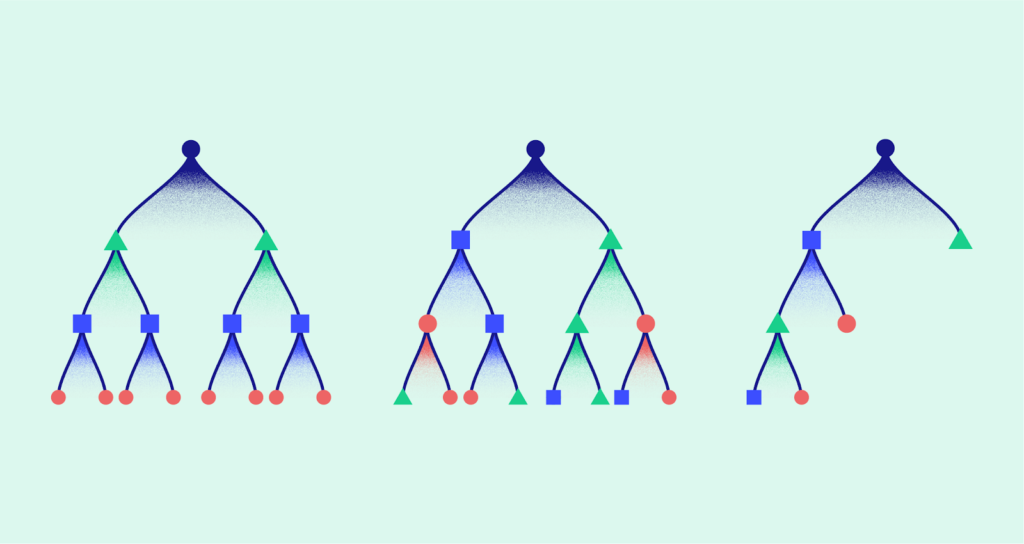


Short Time Fourier Transform (STFT) là một kỹ thuật phân tích tín hiệu để xem xét cách tần số của tín hiệu thay đổi theo thời gian. Nó là một biến thể của Fourier Transform (FT), được áp dụng trên các đoạn nhỏ của tín hiệu (gọi là cửa sổ hoặc window) thay vì toàn bộ tín hiệu. Điều này giúp phân tích các tín hiệu không tĩnh (non-stationary) mà tần số của chúng thay đổi theo thời gian, ví dụ như âm thanh, giọng nói, hoặc các tín hiệu dao động khác.

Nguyên lý hoạt động của STFT
Chia tín hiệu thành các đoạn nhỏ (window):

Tín hiệu được chia thành các đoạn nhỏ, thường có độ dài cố định, nhờ vào một hàm cửa sổ (window function) như Hamming, Hanning, hoặc Gaussian.
Mỗi đoạn chỉ chiếm một phần nhỏ của tín hiệu ban đầu, giả định rằng nó gần như không đổi trong khoảng thời gian ngắn này.
Áp dụng Fourier Transform trên mỗi đoạn nhỏ:

Thực hiện Fourier Transform (FT) trên từng đoạn tín hiệu để chuyển đổi từ miền thời gian sang miền tần số.
Ghép kết quả để tạo ra phổ thời gian-tần số:

Kết quả của STFT là một bản đồ 2D, trong đó một trục biểu diễn thời gian và trục còn lại biểu diễn tần số. Biên độ hoặc pha tại mỗi điểm tương ứng thể hiện mức năng lượng hoặc pha của tín hiệu tại tần số và thời gian cụ thể.
Ứng dụng
Âm thanh và xử lý giọng nói: Nhận diện giọng nói, phân tích âm nhạc, loại bỏ tiếng ồn.
Hệ thống radar và sonar: Phân tích tín hiệu phản xạ để xác định đối tượng.
Y học: Phân tích tín hiệu sinh học như EEG (điện não đồ) hoặc ECG (điện tim đồ).
Kỹ thuật: Phân tích dao động, xác định các vấn đề rung động trong máy móc.
 # Phân tích toán học của Short Time Fourier Transform (STFT)

### **1. Định nghĩa cơ bản của STFT**
STFT của một tín hiệu \( x(t) \) được định nghĩa bằng cách tính Fourier Transform trên các đoạn nhỏ của tín hiệu, sử dụng một hàm cửa sổ \( w(t) \). Biểu thức:

$$
X(t, f) = \int_{-\infty}^\infty x(\tau) \cdot w(\tau - t) \cdot e^{-j 2 \pi f \tau} d\tau
$$

- \( x(t) \): Tín hiệu gốc trong miền thời gian.
- \( w(t) \): Hàm cửa sổ trượt qua tín hiệu (như Hamming, Hanning,...).
- \( t \): Thời gian tại tâm của cửa sổ \( w(t) \).
- \( f \): Tần số trong miền Fourier.
- \( e^{-j 2 \pi f \tau} \): Phần chuyển đổi Fourier (dạng sóng phức).

---

### **2. Các bước phân tích**
#### **Bước 1: Cửa sổ hóa tín hiệu**
Tín hiệu \( x(t) \) được nhân với một hàm cửa sổ \( w(\tau - t) \) để chọn một đoạn nhỏ quanh thời điểm \( t \). Kết quả là một tín hiệu cục bộ \( x_{\text{local}}(\tau, t) \):

$$
x_{\text{local}}(\tau, t) = x(\tau) \cdot w(\tau - t)
$$

#### **Bước 2: Biến đổi Fourier trên đoạn cục bộ**
Lấy Fourier Transform của tín hiệu \( x_{\text{local}}(\tau, t) \):

$$
X(t, f) = \int_{-\infty}^\infty x(\tau) \cdot w(\tau - t) \cdot e^{-j 2 \pi f \tau} d\tau
$$

#### **Ý nghĩa:**
- \( X(t, f) \) là một hàm phức trong miền thời gian \( t \) và miền tần số \( f \).
- Độ lớn \( |X(t, f)| \) biểu diễn năng lượng của tín hiệu ở tần số \( f \) tại thời điểm \( t \).
- Pha \( \angle X(t, f) \) cung cấp thông tin về pha của tín hiệu.

---

### **3. Miền rời rạc (Discrete STFT - DFT)**
Trong thực tế, tín hiệu thường rời rạc với \( x[n] \) (mẫu hóa). STFT được viết lại dưới dạng tổng:

$$
X[m, k] = \sum_{n=-\infty}^\infty x[n] \cdot w[n - m] \cdot e^{-j 2 \pi k n / N}
$$

- \( n \): Chỉ số thời gian.
- \( m \): Chỉ số trung tâm của cửa sổ.
- \( k \): Chỉ số tần số.
- \( N \): Số mẫu trong cửa sổ.

#### **Ứng dụng của DFT:**
- Tách tín hiệu thành các khung (frames).
- Sử dụng thuật toán FFT (Fast Fourier Transform) để tính nhanh.

---

### **4. Trade-off giữa độ phân giải thời gian và tần số**
#### **Cửa sổ ngắn (hẹp):**
- Cung cấp độ phân giải tốt theo thời gian (biết chính xác thời điểm).
- Độ phân giải tần số kém (không biết rõ tần số chi tiết).

#### **Cửa sổ dài (rộng):**
- Cung cấp độ phân giải tốt theo tần số (tần số chính xác hơn).
- Độ phân giải thời gian kém (không rõ khi nào tín hiệu xuất hiện).

**Định luật Heisenberg trong tín hiệu:** Không thể đạt được độ phân giải tốt đồng thời trong cả hai miền thời gian và tần số.

---

### **5. Biểu diễn phổ thời gian-tần số**
Kết quả STFT thường được biểu diễn dưới dạng **spectrogram**:  

$$
\text{Spectrogram}(t, f) = |X(t, f)|^2
$$

- Đây là một bản đồ 2D, với:
  - **Trục x:** Thời gian \( t \).
  - **Trục y:** Tần số \( f \).
  - **Màu sắc:** Cường độ tín hiệu (năng lượng).

---


#### STFT
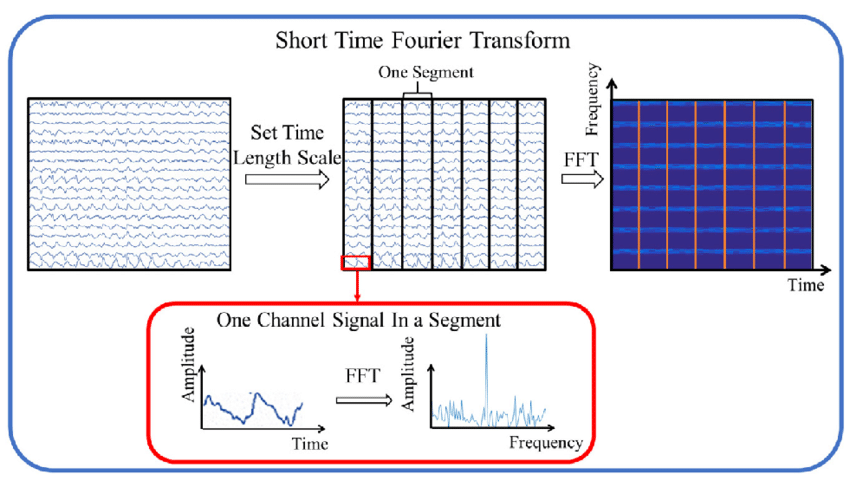
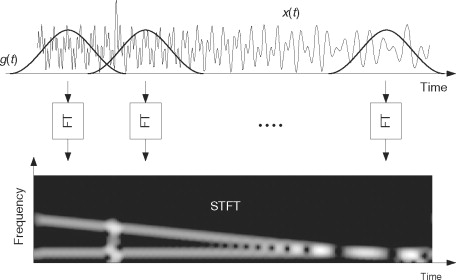

### import thư viện

In [1]:
from scipy.io import loadmat
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import sem
from tensorflow.keras.utils import to_categorical
from scipy.signal import stft
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


### tải dữ liệu

In [2]:

!kaggle datasets download inancigdem/eeg-data-for-mental-attention-state-detection
!unzip "/content/eeg-data-for-mental-attention-state-detection.zip"

Dataset URL: https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection
License(s): copyright-authors
 99% 553M/557M [00:08<00:00, 67.9MB/s]
100% 557M/557M [00:08<00:00, 70.1MB/s]
Archive:  /content/eeg-data-for-mental-attention-state-detection.zip
  inflating: EEG Data/eeg_record1.mat  
  inflating: EEG Data/eeg_record10.mat  
  inflating: EEG Data/eeg_record11.mat  
  inflating: EEG Data/eeg_record12.mat  
  inflating: EEG Data/eeg_record13.mat  
  inflating: EEG Data/eeg_record14.mat  
  inflating: EEG Data/eeg_record15.mat  
  inflating: EEG Data/eeg_record16.mat  
  inflating: EEG Data/eeg_record17.mat  
  inflating: EEG Data/eeg_record18.mat  
  inflating: EEG Data/eeg_record19.mat  
  inflating: EEG Data/eeg_record2.mat  
  inflating: EEG Data/eeg_record20.mat  
  inflating: EEG Data/eeg_record21.mat  
  inflating: EEG Data/eeg_record22.mat  
  inflating: EEG Data/eeg_record23.mat  
  inflating: EEG Data/eeg_record24.mat  
  inflating: EEG Data/eeg_

#2.Feature engineering (sử dụng stft trên từng mảng và chuyển đổi tín hiệu sang db).

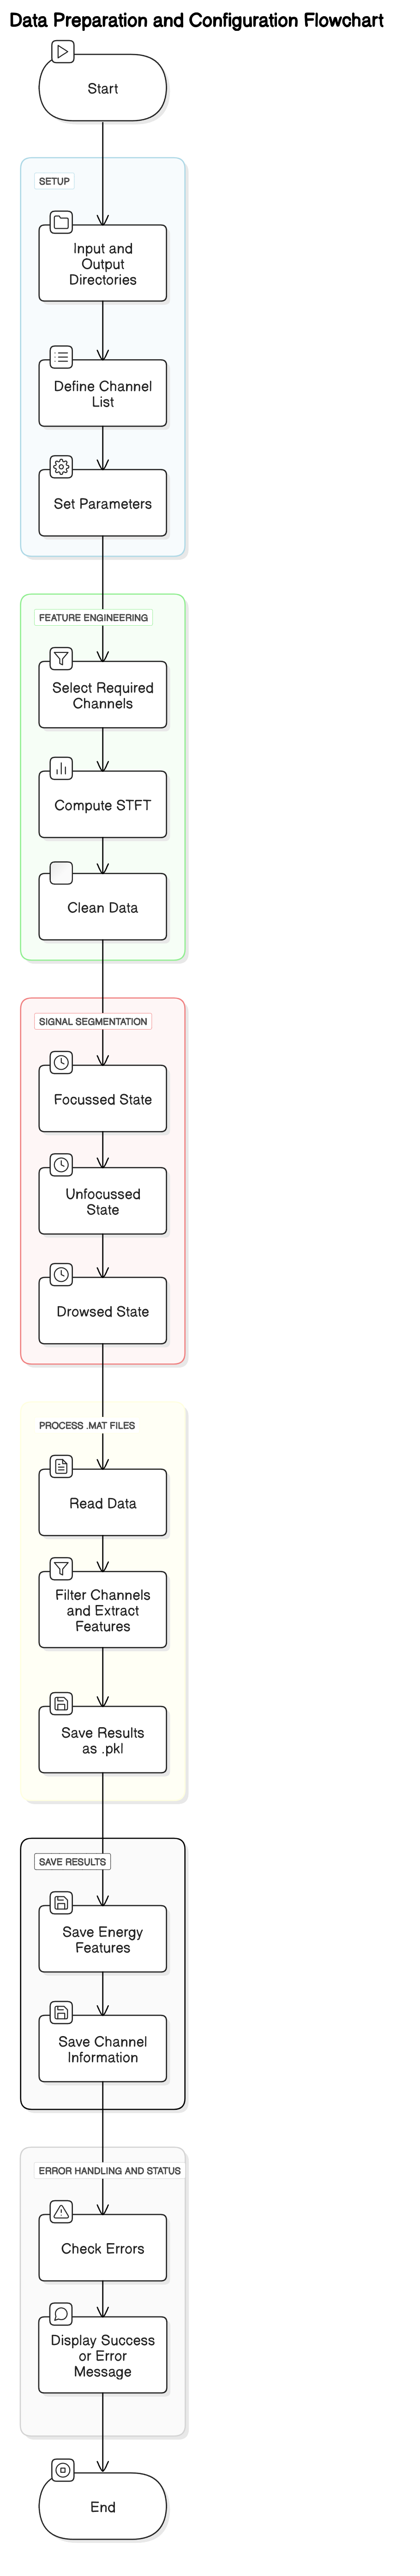

### 2.1 Xây dựng Class xữ lí số liệu.

Đầu tiên,khởi tạo với các tham số như tần số lấy mẫu danh sách các kênh tín hiệu cần thiết và độ dài tín hiệu .
Sau đó, định vị  kênh cần thiết trong danh sách tất cả các kênh. Để phân tích tín hiệu, phương thức sử dụng phương thức STFT chuyển đổi tín hiệu từ miền thời gian sang miền tần số thông qua phép biến đổi Fourier ngắn hạn (stft), trả về các giá trị tần số, thời gian, và phổ biên độ của tín hiệu.
Tiếp theo, phương thức chia tín hiệu thành các phân đoạn nhỏ theo khoảng thời gian   và bước nhảy, sau đó tính phổ thời gian thông qua stft. Phương pháp này chỉ giữ các tần số hữu ích (≤ 30 hz) để loại bỏ nhiễu, đồng thời chuẩn hóa năng lượng tín hiệu qua thang decibel (db). Phương thức  làm sạch dữ liệu bằng cách giới hạn tín hiệu trong khoảng thời gian nhất định, sau đó trích xuất các đặc trưng năng lượng từ các phân đoạn tín hiệu sau đó sử dụng min max scaler để chuẩn hóa dữ liệu về dạng 0-1.
Cuối cùng, pipeline chính xử lý toàn bộ dữ liệu eeg từ các tệp mat. Dữ liệu được chia thành ba trạng thái: focussed (10 phút đầu), unfocussed (10 phút tiếp theo), và drowsed (10 phút cuối).
Mỗi trạng thái được làm sạch và trích xuất đặc trưng riêng biệt. Kết quả xử lý được lưu vào các tệp .pkl, chứa dữ liệu tín hiệu đã được xử lý, danh sách các kênh hữu ích, và tần số lấy mẫu, để phục vụ cho các bước phân tích hoặc huấn luyện mô hình tiếp theo
Đặc biệt khác với phương pháp xữ lí SVM hay KNN thì DATA được đưa về dạng thang Db để dễ dễ thấy sự phân cách của dữ liệu hơn..


In [3]:

class FeatureEngineering:
    def __init__(self, fs=128, useful_channels=None, duration=30):
        self.fs = fs
        self.useful_channels = useful_channels if useful_channels else []
        self.duration = duration

    def get_useful_channel_indices(self, all_channels):
        """Lấy chỉ số các kênh cần thiết từ danh sách kênh."""
        return [all_channels.index(c) for c in self.useful_channels if c in all_channels]

    @staticmethod
    def STFTTransform(data, fs=128, bin_hz=0.5):
        """
        Chuyển đổi tín hiệu sử dụng Short-Time Fourier Transform (STFT) với độ phân giải tần số theo bin Hz.

        Parameters:
        - data: Tín hiệu đầu vào (một chiều).
        - fs: Tần số lấy mẫu.
        - bin_hz: Độ phân giải tần số trong mỗi bin (Hz).

        Returns:
        - freqs: Các tần số tương ứng.
        - times: Các thời điểm tương ứng.
        - Zxx: Phổ STFT (phức).
        """
        # Tính số điểm trong mỗi segment từ độ phân giải tần số
        nperseg = int(fs / bin_hz)

        # Tính STFT
        freqs, times, Zxx = stft(data, fs=fs, nperseg=nperseg)
        return freqs, times, np.abs(Zxx)

    def getTimeSpectrum(self, data, fs=128, interval=8, step=2, bin_hz=0.5):
        """
        Tính phổ thời gian sử dụng STFT.

        Parameters:
        - data: Tín hiệu đầu vào.
        - fs: Tần số lấy mẫu.
        - interval: Độ dài của mỗi phân đoạn (giây).
        - step: Bước nhảy giữa các phân đoạn (giây).
        - bin_hz: Độ phân giải tần số trong mỗi bin (Hz).

        Returns:
        - energy: Đặc trưng năng lượng sau khi tính STFT và chuẩn hóa.
        """
        window_size = int(interval * fs)  # Số mẫu trong mỗi phân đoạn
        step_size = int(step * fs)  # Số mẫu bước nhảy
        energy = []

        for start in range(0, len(data) - window_size, step_size):
            window_data = data[start:start + window_size]
            freqs, times, Zxx = self.STFTTransform(window_data, fs=fs, bin_hz=bin_hz)
            # Chỉ lấy các giá trị STFT tương ứng với tần số <= fmax
            valid_freqs = freqs[freqs <= 30]  # Lọc tần số tối đa là 40 Hz
            valid_Zxx = np.abs(Zxx[:len(valid_freqs), :])
            # Tính năng lượng (bình phương độ lớn)
            energy.append(np.sum(valid_Zxx ** 2, axis=1))
        energy = self.power_to_dB(energy)
        scaler = MinMaxScaler()
        energy = scaler.fit_transform(energy)

        return np.array(energy)

    def cleanData(self, data, fmax=40, interval=8, step=1, bin_hz=0.5):
        """Làm sạch dữ liệu và trích xuất đặc trưng năng lượng bằng STFT."""
        max_samples = self.duration * 60 * self.fs
        data = data[:, :max_samples]

        energy_features = []
        for i in range(data.shape[0]):
            energy_features.append(self.getTimeSpectrum(
                data[i], fs=self.fs, interval=interval, step=step, bin_hz=bin_hz
            ))

        E = np.array(energy_features)
        E = E.reshape([E.shape[1], E.shape[0], E.shape[2]], order='F')
        return E

    @staticmethod
    def power_to_dB(power):
        """
        Chuyển đổi giá trị công suất sang đơn vị decibel (dB).

        Parameters:
        - power: Mảng hoặc giá trị công suất (Power).

        Returns:
        - dB: Mảng hoặc giá trị tương ứng trong đơn vị decibel (dB).
        """
        power = np.maximum(power, 1e-10)  # Thay giá trị <= 0 bằng một giá trị nhỏ nhất để tránh log(0)
        return abs(10 * np.log10(power))


def process_eeg_data(input_dir, output_dir, channels, useful_channels, fs=128, interval=8, step=1, bin_hz=0.5):
    """Pipeline xử lý dữ liệu EEG."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    feature_engineer = FeatureEngineering(fs=fs, useful_channels=useful_channels)
    use_channel_inds = feature_engineer.get_useful_channel_indices(channels)

    mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]
    for file_name in mat_files:
        try:
            # Tải dữ liệu từ tệp .mat
            trial_data = loadmat(os.path.join(input_dir, file_name))
            eeg = np.transpose(trial_data['o']['data'][0][0][:, 3:17])
            eeg = eeg[use_channel_inds]

            # Làm sạch và trích xuất đặc trưng đồng thời sftf dữ liệu trong từng khoảng chia cụ thể.
            eeg_focused = feature_engineer.cleanData(eeg[:,0:10*60*fs], fmax=40, interval=interval, step=step, bin_hz=bin_hz)
            eeg_unfocused = feature_engineer.cleanData(eeg[:,10*60*fs:20*60*fs], fmax=40, interval=interval, step=step, bin_hz=bin_hz)
            eeg_drowsed = feature_engineer.cleanData(eeg[:,20*60*fs:30*60*fs], fmax=40, interval=interval, step=step, bin_hz=bin_hz)

            trial = {
                'focussed': eeg_focused,
                'unfocussed': eeg_unfocused,
                'drowsed': eeg_drowsed,
            }

            # Lưu dữ liệu
            data = {
                'channels': useful_channels,
                'fs': fs,
                'trial': trial,
            }
            output_file = os.path.join(output_dir, f'{file_name[:-4]}.pkl')
            with open(output_file, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

            print(f'Đã xử lý tệp {file_name} và lưu vào {output_file}')
        except Exception as e:
            print(f"Lỗi khi xử lý tệp {file_name}: {e}")


# Cấu hình và chạy pipeline
if __name__ == "__main__":
    input_dir = '/content/eeg data/EEG Data'
    output_dir = '/content/data_for_XGBoost'
    fs = 128
    channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    useful_channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']

    process_eeg_data(input_dir, output_dir, channels, useful_channels, fs=fs, interval=8, step=8, bin_hz=0.5)

Đã xử lý tệp eeg_record9.mat và lưu vào /content/data_for_XGBoost/eeg_record9.pkl
Đã xử lý tệp eeg_record15.mat và lưu vào /content/data_for_XGBoost/eeg_record15.pkl
Đã xử lý tệp eeg_record3.mat và lưu vào /content/data_for_XGBoost/eeg_record3.pkl
Đã xử lý tệp eeg_record34.mat và lưu vào /content/data_for_XGBoost/eeg_record34.pkl
Đã xử lý tệp eeg_record29.mat và lưu vào /content/data_for_XGBoost/eeg_record29.pkl
Đã xử lý tệp eeg_record11.mat và lưu vào /content/data_for_XGBoost/eeg_record11.pkl
Đã xử lý tệp eeg_record2.mat và lưu vào /content/data_for_XGBoost/eeg_record2.pkl
Đã xử lý tệp eeg_record5.mat và lưu vào /content/data_for_XGBoost/eeg_record5.pkl
Đã xử lý tệp eeg_record7.mat và lưu vào /content/data_for_XGBoost/eeg_record7.pkl
Đã xử lý tệp eeg_record18.mat và lưu vào /content/data_for_XGBoost/eeg_record18.pkl
Đã xử lý tệp eeg_record26.mat và lưu vào /content/data_for_XGBoost/eeg_record26.pkl
Đã xử lý tệp eeg_record20.mat và lưu vào /content/data_for_XGBoost/eeg_record20.pkl
Đã

In [5]:
# prompt: nén zip thư mục này /content/data_for_XGBoost

!zip -r /content/data_for_XGBoost.zip /content/data_for_XGBoost


  adding: content/data_for_XGBoost/ (stored 0%)
  adding: content/data_for_XGBoost/eeg_record8.pkl (deflated 15%)
  adding: content/data_for_XGBoost/eeg_record19.pkl (deflated 16%)
  adding: content/data_for_XGBoost/eeg_record4.pkl (deflated 14%)
  adding: content/data_for_XGBoost/eeg_record7.pkl (deflated 15%)
  adding: content/data_for_XGBoost/eeg_record16.pkl (deflated 16%)
  adding: content/data_for_XGBoost/eeg_record14.pkl (deflated 16%)
  adding: content/data_for_XGBoost/eeg_record32.pkl (deflated 15%)
  adding: content/data_for_XGBoost/eeg_record21.pkl (deflated 16%)
  adding: content/data_for_XGBoost/eeg_record11.pkl (deflated 16%)
  adding: content/data_for_XGBoost/eeg_record28.pkl (deflated 14%)
  adding: content/data_for_XGBoost/eeg_record24.pkl (deflated 15%)
  adding: content/data_for_XGBoost/eeg_record12.pkl (deflated 15%)
  adding: content/data_for_XGBoost/eeg_record9.pkl (deflated 15%)
  adding: content/data_for_XGBoost/eeg_record25.pkl (deflated 14%)
  adding: content/

In [4]:
with open('/content/data_for_SVM/eeg_record5.pkl', 'rb') as f:
  loaded_data = pickle.load(f)

loaded_data

FileNotFoundError: [Errno 2] No such file or directory: '/content/data_for_SVM/eeg_record5.pkl'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 Vẽ Hình Kiểm tra thử một kênh và vẽ thêm với mức đo là 10%.

In [ ]:
data_channel_2 = loaded_data['trial']['focussed'][:,2,:]

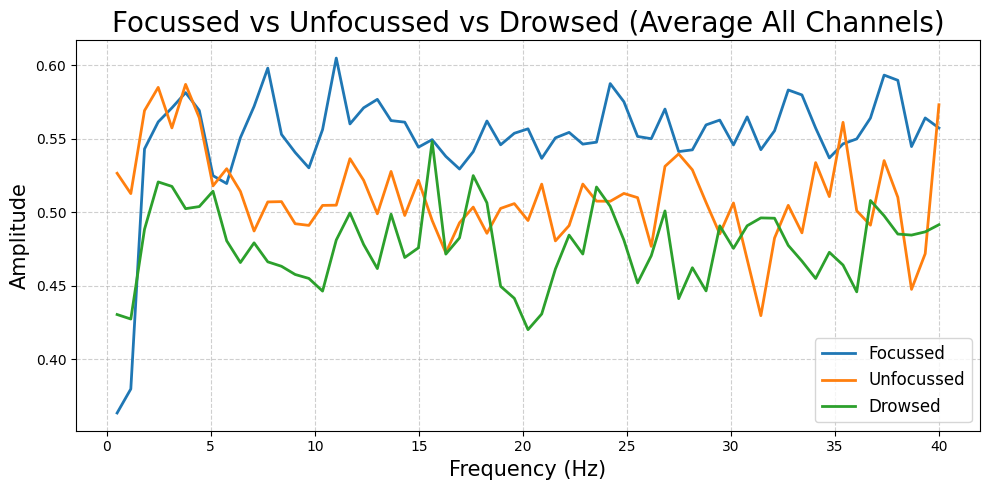

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tính toán trung bình năng lượng cho từng trạng thái
focussed_avg_all = loaded_data['trial']['focussed'].mean(axis=1)
unfocussed_avg_all = loaded_data['trial']['unfocussed'].mean(axis=1)
drowsed_avg_all = loaded_data['trial']['drowsed'].mean(axis=1)

# Trục tần số (0.5 Hz đến 40 Hz)
freq_range = np.linspace(0.5, 40, focussed_avg_all.shape[1])

# Tạo đồ thị
plt.figure(figsize=(10, 5))
plt.title('Focussed vs Unfocussed vs Drowsed (Average All Channels)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)

# Vẽ các đường trung bình
plt.plot(freq_range, focussed_avg_all.mean(axis=0), label='Focussed', linewidth=2)
plt.plot(freq_range, unfocussed_avg_all.mean(axis=0), label='Unfocussed', linewidth=2)
plt.plot(freq_range, drowsed_avg_all.mean(axis=0), label='Drowsed', linewidth=2)

# Thêm chú thích và hiển thị
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


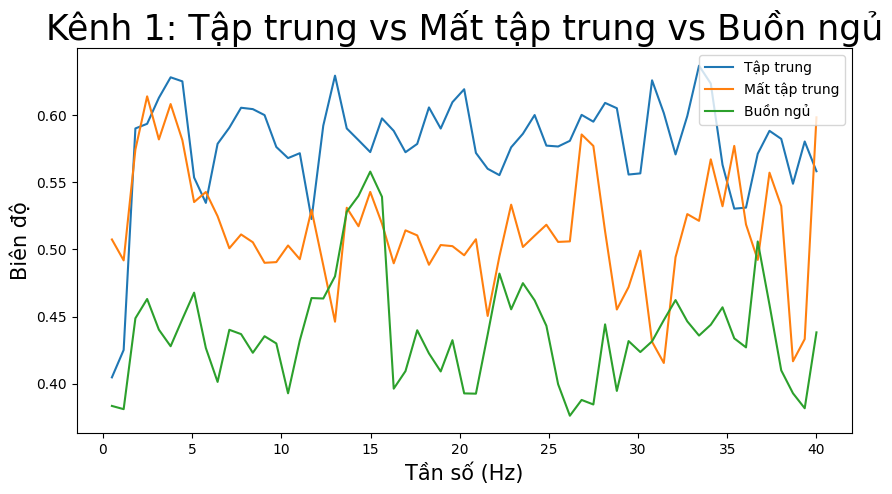

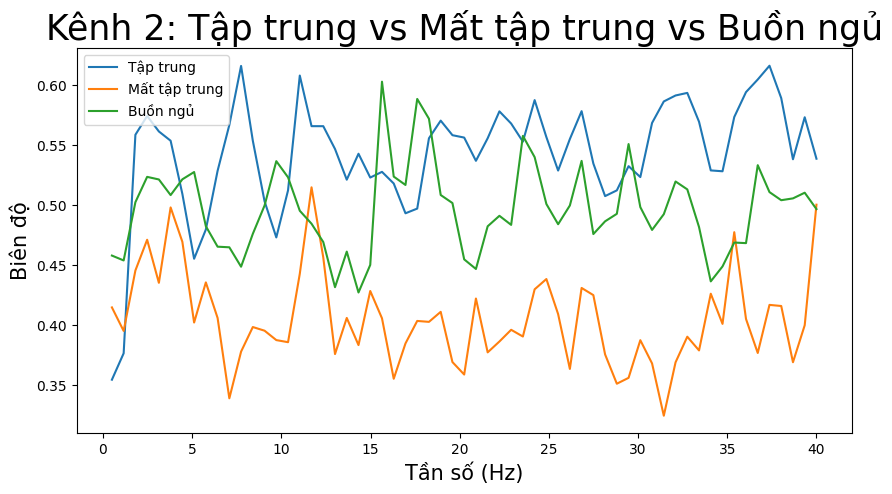

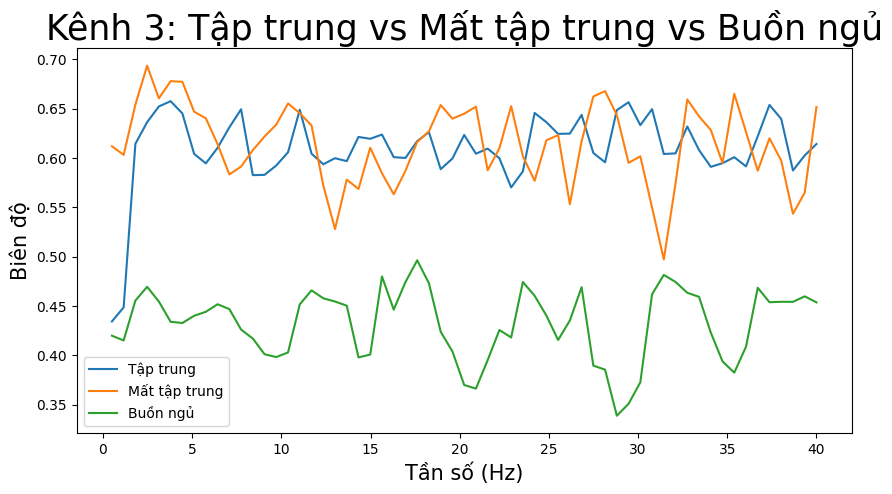

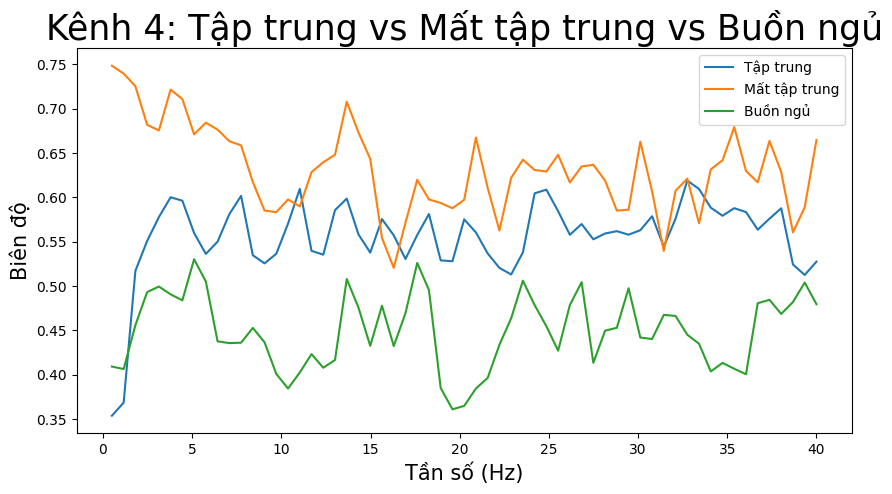

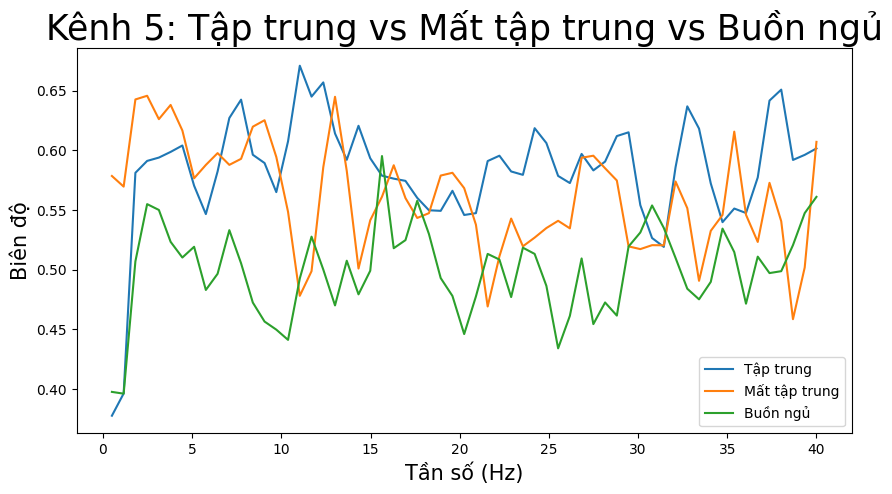

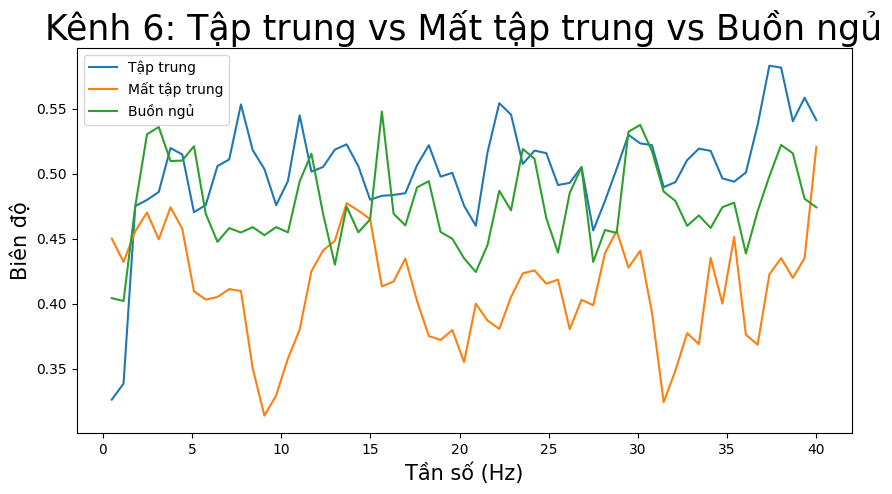

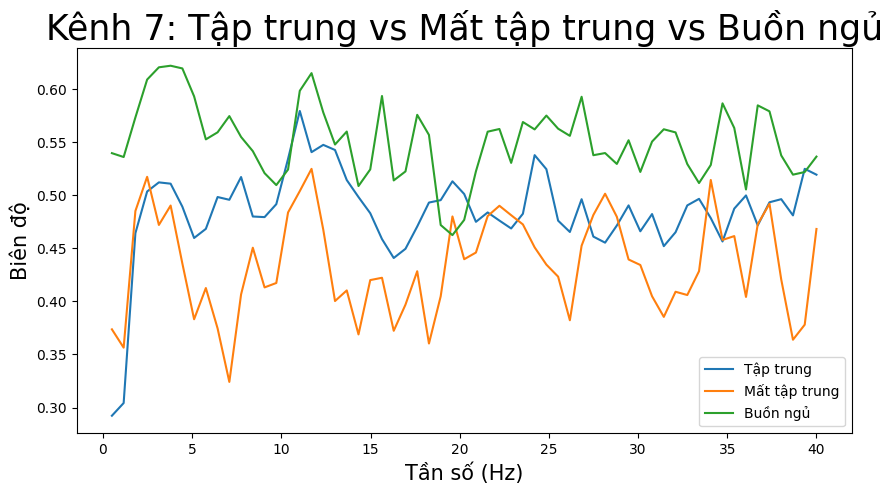

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Lặp qua từng kênh trong dữ liệu
num_channels = loaded_data['trial']['focussed'].shape[1]  # Số lượng kênh

for channel in range(num_channels):
    # Trích xuất dữ liệu của kênh hiện tại cho từng trạng thái
    focussed_channel = loaded_data['trial']['focussed'][:, channel, :]  # Dữ liệu trạng thái tập trung
    unfocussed_channel = loaded_data['trial']['unfocussed'][:, channel, :]  # Dữ liệu trạng thái mất tập trung
    drowsed_channel = loaded_data['trial']['drowsed'][:, channel, :]  # Dữ liệu trạng thái buồn ngủ

    # Tính trung bình biên độ theo tần số cho mỗi trạng thái
    frequency_range = np.linspace(0.5, 40, focussed_channel.shape[1])  # Khoảng tần số từ 0.5 đến 40 Hz
    focussed_mean = focussed_channel.mean(axis=0)  # Biên độ trung bình cho trạng thái tập trung
    unfocussed_mean = unfocussed_channel.mean(axis=0)  # Biên độ trung bình cho trạng thái mất tập trung
    drowsed_mean = drowsed_channel.mean(axis=0)  # Biên độ trung bình cho trạng thái buồn ngủ

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))  # Kích thước biểu đồ
    plt.title(f'Kênh {channel + 1}: Tập trung vs Mất tập trung vs Buồn ngủ', fontsize=25)  # Tiêu đề
    plt.xlabel('Tần số (Hz)', fontsize=15)  # Nhãn trục X
    plt.ylabel('Biên độ', fontsize=15)  # Nhãn trục Y

    # Vẽ các đường biểu diễn cho từng trạng thái
    plt.plot(frequency_range, focussed_mean, label='Tập trung')  # Đường biểu diễn trạng thái tập trung
    plt.plot(frequency_range, unfocussed_mean, label='Mất tập trung')  # Đường biểu diễn trạng thái mất tập trung
    plt.plot(frequency_range, drowsed_mean, label='Buồn ngủ')  # Đường biểu diễn trạng thái buồn ngủ

    plt.legend()  # Hiển thị chú thích
    plt.show()  # Hiển thị biểu đồ


## 3.Tiến hành xây dựng pipeline train model.

Giải thích các phương thức trong lớp `Pipeline`

#### 1. `__init__(self, folder_path, batch_size=512, test_size=0.2, random_state=33)`
- **Chức năng**: Khởi tạo đối tượng `Pipeline` với các tham số như đường dẫn thư mục chứa dữ liệu, kích thước batch, tỷ lệ dữ liệu kiểm tra và giá trị ngẫu nhiên.
- **Các tham số**:
  - `folder_path`: Đường dẫn tới thư mục chứa dữ liệu.
  - `batch_size`: Số lượng mẫu trong mỗi batch (mặc định là 512).
  - `test_size`: Tỷ lệ dữ liệu kiểm tra (mặc định là 0.2, tức 20% dữ liệu dùng để kiểm tra).
  - `random_state`: Giá trị ngẫu nhiên cố định để đảm bảo tính tái lặp của kết quả.
- **Các thuộc tính khởi tạo**:
  - `scaler`: Khởi tạo đối tượng `StandardScaler` để chuẩn hóa dữ liệu.
  - `train_data`, `test_data`: Biến lưu trữ dữ liệu huấn luyện và kiểm tra.
  - `model`: Biến lưu trữ mô hình (chưa khởi tạo).
  - `loss_history`, `accuracy_history`: Lịch sử lưu trữ lỗi và độ chính xác cho quá trình huấn luyện và kiểm tra.

#### 2. `load_data(self)`
- **Chức năng**: Tải và chia dữ liệu từ các tệp `.pkl` trong thư mục.
- **Quy trình**:
  - Duyệt qua tất cả các tệp `.pkl` trong thư mục.
  - Mỗi tệp chứa dữ liệu cho ba trạng thái: `focussed`, `unfocussed`, và `drowsed`, sau đó gán nhãn tương ứng (2, 1, 0).
  - Kết hợp tất cả dữ liệu lại với nhau và xáo trộn chúng.
  - Chia dữ liệu thành tập huấn luyện và tập kiểm tra bằng `train_test_split`.

#### 3. `preprocess_data(self, Xtrain, Xtest, ytrain, ytest)`
- **Chức năng**: Chuẩn hóa dữ liệu bằng cách sử dụng `StandardScaler`.
- **Quy trình**:
  - Áp dụng `fit_transform` cho dữ liệu huấn luyện `Xtrain`.
  - Áp dụng `transform` cho dữ liệu kiểm tra `Xtest` (đảm bảo dùng cùng một bộ tham số chuẩn hóa).
  - Lưu trữ dữ liệu đã chuẩn hóa vào `train_data` và `test_data`.

#### 4. `initialize_model(self, lr=0.1, max_depth=10, n_estimators=100)`
- **Chức năng**: Khởi tạo mô hình XGBoost với các tham số như learning rate, độ sâu tối đa của cây và số lượng cây.
- **Quy trình**:
  - Sử dụng `xgb.XGBClassifier` với các tham số như `tree_method="hist"` (phương pháp histogram để huấn luyện nhanh hơn), `device="cuda"` (sử dụng GPU).

#### 5. `train(self, epochs=1)`
- **Chức năng**: Huấn luyện mô hình XGBoost.
- **Quy trình**:
  - Sử dụng phương thức `fit` của XGBoost để huấn luyện mô hình với dữ liệu huấn luyện.

#### 6. `evaluate(self, data)`
- **Chức năng**: Đánh giá mô hình trên dữ liệu kiểm tra.
- **Quy trình**:
  - Sử dụng phương thức `predict` để dự đoán nhãn cho dữ liệu kiểm tra.
  - Tính toán độ chính xác bằng cách so sánh các dự đoán với nhãn thật.

#### 7. `plot_history(self, evals_result)`
- **Chức năng**: Vẽ biểu đồ lịch sử học của mô hình, bao gồm Log Loss và Error Rate.
- **Quy trình**:
  - Sử dụng `matplotlib` để vẽ biểu đồ của Log Loss và Error Rate cho cả tập huấn luyện và tập kiểm tra qua các epoch.

#### 8. `evaluate_with_metrics(self, data)`
- **Chức năng**: Đánh giá mô hình với các chỉ số chi tiết như ma trận nhầm lẫn và báo cáo phân loại.
- **Quy trình**:
  - Sử dụng `confusion_matrix` và `classification_report` từ `sklearn.metrics` để tính toán các chỉ số như độ chính xác, ma trận nhầm lẫn và báo cáo phân loại chi tiết.

#### 9. `save_best_model(self, save_path="best_model.xgb")`
- **Chức năng**: Lưu mô hình XGBoost đã huấn luyện vào tệp.
- **Quy trình**:
  - Sử dụng phương thức `save_model` của mô hình XGBoost để lưu mô hình vào tệp.

#### 10. `load_model(self, model_path="best_model.xgb")`
- **Chức năng**: Tải mô hình XGBoost đã lưu từ tệp.
- **Quy trình**:
  - Sử dụng phương thức `load_model` của mô hình XGBoost để tải mô hình từ tệp.

#### 11. `plot_confusion_matrix(self, cm)`
- **Chức năng**: Vẽ ma trận nhầm lẫn.
- **Quy trình**:
  - Sử dụng `seaborn.heatmap` để vẽ ma trận nhầm lẫn với các nhãn thật và nhãn dự đoán.

#### 12. `tune_hyperparameters(self, param_grid)`
- **Chức năng**: Tinh chỉnh các siêu tham số của mô hình XGBoost bằng cách sử dụng `GridSearchCV`.
- **Quy trình**:
  - Khởi tạo mô hình XGBoost.
  - Sử dụng `GridSearchCV` để tìm ra bộ siêu tham số tốt nhất dựa trên độ chính xác với kỹ thuật kiểm tra chéo (cross-validation).
  - Cập nhật mô hình với mô hình tốt nhất từ `GridSearchCV`.


### Xây dựng cái pipeline.

### Pipeline cho học máy


Các Bước Chính trong Đoạn Mã
Khởi Tạo Đường Dẫn Dữ Liệu:
Biến này lưu trữ đường dẫn đến thư mục chứa dữ liệu mà bạn sẽ sử dụng cho mô hình. \
Tạo Pipeline: \
Khởi tạo một đối tượng Pipeline với đường dẫn đến dữ liệu. Đối tượng này sẽ chứa các phương thức để xử lý dữ liệu, huấn luyện mô hình, và đánh giá mô hình. \
Bước 1: Tải và Tiền Xử Lý Dữ Liệu:\
Tải dữ liệu từ thư mục đã chỉ định và chia thành tập huấn luyện và tập kiểm tra.
Thực hiện các bước tiền xử lý cần thiết trên dữ liệu, như chuẩn hóa, loại bỏ giá trị thiếu, hoặc biến đổi đặc trưng. \
Bước 2: Khởi Tạo Mô Hình XGBoost: \
Khởi tạo mô hình XGBoost với các tham số như tốc độ học, độ sâu tối đa của cây, và số lượng cây trong mô hình.
Huấn luyện mô hình trong một số lượng epoch đã chỉ định.
Bước 3: Đánh Giá Mô Hình: \
Tính toán độ chính xác của mô hình trên tập kiểm tra và trả về độ chính xác cùng với dự đoán. \
In ra kết quả độ chính xác với định dạng cụ thể. \
Đánh Giá Chi Tiết với Các Metric: \
Tính toán các metrics khác như ma trận nhầm lẫn và báo cáo phân loại.
In ra báo cáo phân loại và vẽ ma trận nhầm lẫn. \
Bước 4: Lưu Mô Hình Tốt Nhất: \
Lưu mô hình tốt nhất vào file với tên đã chỉ định.  

In [ ]:


class Pipeline:
    def __init__(self, folder_path, batch_size=512, test_size=0.2, random_state=33):
        """Khởi tạo pipeline xử lý dữ liệu và mô hình."""
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()  # Sử dụng StandardScaler để chuẩn hóa dữ liệu
        self.train_data = None
        self.test_data = None
        self.model = None
        self.loss_history = {"train": [], "test": []}  # Lịch sử lỗi huấn luyện và kiểm tra
        self.accuracy_history = {"train": [], "test": []}  # Lịch sử độ chính xác

    def load_data(self):
        """Tải và chia dữ liệu từ các file .pkl trong thư mục."""
        X_list, y_list = [], []
        # Duyệt qua tất cả các file trong thư mục
        for file_name in os.listdir(self.folder_path):
            if file_name.endswith('.pkl'):
                file_path = os.path.join(self.folder_path, file_name)
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)
                # Tải dữ liệu cho ba trạng thái: tập trung, mất tập trung, buồn ngủ
                x1, x2, x3 = data['trial']['focussed'], data['trial']['unfocussed'], data['trial']['drowsed']
                y1, y2, y3 = np.full(len(x1), 2), np.full(len(x2), 1), np.full(len(x3), 0)
                X_list.extend([x1, x2, x3])
                y_list.extend([y1, y2, y3])
        # Kết hợp dữ liệu
        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0)
        X = X.reshape(X.shape[0], -1)  # Chuyển dạng dữ liệu thành mảng 2D
        perm = np.random.permutation(X.shape[0])  # Xáo trộn dữ liệu
        return train_test_split(X[perm], y[perm], test_size=self.test_size, random_state=self.random_state)

    def preprocess_data(self, Xtrain, Xtest, ytrain, ytest):
        """Chuẩn hóa dữ liệu sử dụng StandardScaler."""
        Xtrain = self.scaler.fit_transform(Xtrain)
        Xtest = self.scaler.transform(Xtest)
        self.train_data = (Xtrain, ytrain)
        self.test_data = (Xtest, ytest)

    def initialize_model(self, lr=0.1, max_depth=10, n_estimators=100):
        """Khởi tạo mô hình XGBoost với hỗ trợ GPU."""
        self.model = xgb.XGBClassifier(
            tree_method="hist",  # Phương pháp histogram-based cho huấn luyện nhanh hơn
            device="cuda",       # Sử dụng GPU (CUDA)
            n_estimators=n_estimators,
            learning_rate=lr,
            max_depth=max_depth
        )

    def train(self, epochs=1):
        """Huấn luyện mô hình XGBoost."""
        Xtrain, ytrain = self.train_data
        self.model.fit(Xtrain, ytrain)
        print(f"Model trained for {epochs} epoch(s).")

    def evaluate(self, data):
        """Đánh giá mô hình trên dữ liệu kiểm tra."""
        Xtest, ytest = data
        ypred = self.model.predict(Xtest)
        accuracy = np.mean(ypred == ytest)  # Tính độ chính xác
        return accuracy, ypred

    def plot_history(self, evals_result):
        """Vẽ biểu đồ lịch sử học của mô hình (Log Loss và Error Rate)."""
        epochs = range(1, len(evals_result['train']['logloss']) + 1)

        # Biểu đồ Log Loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, evals_result['train']['logloss'], label='Train Log Loss')
        plt.plot(epochs, evals_result['validation']['logloss'], label='Validation Log Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Log Loss")
        plt.title("Log Loss History")
        plt.legend()

        # Biểu đồ Error Rate (tỷ lệ lỗi)
        plt.subplot(1, 2, 2)
        plt.plot(epochs, evals_result['train']['error'], label='Train Error Rate')
        plt.plot(epochs, evals_result['validation']['error'], label='Validation Error Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Error Rate")
        plt.title("Error Rate History")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluate_with_metrics(self, data):
        """Đánh giá mô hình với các chỉ số chi tiết như ma trận nhầm lẫn và báo cáo phân loại."""
        Xtest, ytest = data
        ypred = self.model.predict(Xtest)
        cm = confusion_matrix(ytest, ypred)  # Ma trận nhầm lẫn
        report = classification_report(ytest, ypred, target_names=[str(i) for i in range(len(cm))])  # Báo cáo phân loại
        return cm, report

    def save_best_model(self, save_path="best_model.xgb"):
        """Lưu mô hình XGBoost đã huấn luyện."""
        self.model.save_model(save_path)

    def load_model(self, model_path="best_model.xgb"):
        """Tải mô hình XGBoost đã lưu."""
        self.model.load_model(model_path)

    def plot_confusion_matrix(self, cm):
        """Vẽ ma trận nhầm lẫn."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

    def tune_hyperparameters(self, param_grid):
        """Tinh chỉnh các siêu tham số sử dụng GridSearchCV."""
        Xtrain, ytrain = self.train_data
        xgb_model = xgb.XGBClassifier(tree_method="hist", device="cuda")  # Khởi tạo mô hình XGBoost mà không có tham số siêu
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                                   scoring='accuracy', cv=5, verbose=1, n_jobs=-1)  # n_jobs=-1 sử dụng tất cả các lõi CPU
        grid_search.fit(Xtrain, ytrain)

        print("Best hyperparameters:", grid_search.best_params_)
        print("Best accuracy:", grid_search.best_score_)

        # Lưu mô hình tốt nhất
        self.model = grid_search.best_estimator_


### 4.1 tiến hành hyparameter.

In [ ]:

if __name__ == "__main__":
    # Đường dẫn đến thư mục chứa dữ liệu
    folder_path = '/content/data_for_XGBoost'

    # Khởi tạo pipeline xử lý và huấn luyện
    pipeline = Pipeline(folder_path)

    # Bước 1: Load và xử lý dữ liệu
    X_train, X_test, y_train, y_test = pipeline.load_data()  # Tải dữ liệu
    pipeline.preprocess_data(X_train, X_test, y_train, y_test)  # Tiền xử lý dữ liệu

    # Giới hạn chỉ sử dụng 10% dữ liệu huấn luyện
    X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

    # Bước 2: Khởi tạo mô hình (nếu chưa khởi tạo trước đó)
    pipeline.initialize_model(lr=0.1, max_depth=10, n_estimators=200)  # Cấu hình tham số mô hình

    # Bước 3: Định nghĩa lưới tham số cho việc tinh chỉnh siêu tham số
    param_grid = {
        'n_estimators': [200],  # Số lượng cây trong mô hình
        'learning_rate': [0.1],  # Tốc độ học
        'max_depth': [10],  # Độ sâu tối đa của mỗi cây
        'subsample': [0.8, 0.9],  # Tỷ lệ mẫu con cho mỗi cây
        'colsample_bytree': [0.8, 0.9],  # Tỷ lệ tính toán cột cho mỗi cây
        'gamma': [0, 0.1],  # Giảm độ lỗi tối thiểu để thực hiện phân chia tiếp theo ở nút lá
    }

    # Bước 4: Tinh chỉnh siêu tham số
    pipeline.tune_hyperparameters(param_grid)  # Thực hiện việc tìm kiếm tham số tối ưu


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best accuracy: 0.7907410389270796


Model trained for 1 epoch(s).
Test Accuracy: 0.8096
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       461
           1       0.81      0.77      0.79       525
           2       0.83      0.84      0.84       521

    accuracy                           0.81      1507
   macro avg       0.81      0.81      0.81      1507
weighted avg       0.81      0.81      0.81      1507



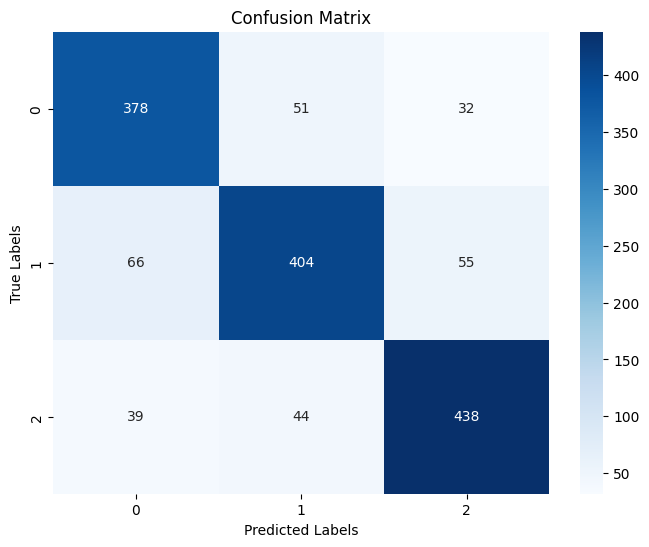

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:27:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [ ]:
if __name__ == "__main__":
    # Đường dẫn đến thư mục chứa dữ liệu
    folder_path = '/content/data_for_XGBoost'

    # Khởi tạo pipeline xử lý và huấn luyện
    pipeline = Pipeline(folder_path)

    # Bước 1: Load và xử lý dữ liệu
    X_train, X_test, y_train, y_test = pipeline.load_data()  # Tải dữ liệu
    pipeline.preprocess_data(X_train, X_test, y_train, y_test)  # Tiền xử lý dữ liệu

    # Bước 2: Khởi tạo mô hình XGBoost với GPU
    pipeline.initialize_model(lr=0.1, max_depth=10, n_estimators=200)  # Cấu hình tham số mô hình với leaning rate 0.1
    pipeline.train(epochs=1)  # Huấn luyện mô hình

    # Bước 3: Đánh giá mô hình
    accuracy, y_pred = pipeline.evaluate(pipeline.test_data)  # Tính độ chính xác
    print(f"Test Accuracy: {accuracy:.4f}")  # In kết quả độ chính xác

    # Đánh giá chi tiết với các metric
    confusion_matrix, classification_report = pipeline.evaluate_with_metrics(pipeline.test_data)
    print("Classification Report:\n", classification_report)  # In báo cáo phân loại
    pipeline.plot_confusion_matrix(confusion_matrix)  # Vẽ ma trận nhầm lẫn

    # Bước 4: Lưu mô hình tốt nhất
    pipeline.save_best_model("_model.xgb")  # Lưu mô hình vào file
